# Extracting object from background

In [3]:
import matplotlib.pyplot as plt
import os
import random
from commonfunctions import *
from skimage.morphology import erosion, dilation, opening, closing
from skimage.filters import median
from skimage.filters import gaussian

### Image Reading

In [5]:
#Step1: Read colored image.
# img = io.imread('./Test Images/coffee.jpeg').astype(np.uint8)
imgs = [
    # io.imread('./Test Images/pyramids.jpeg').astype(np.uint8),
    # io.imread('./Test Images/coffee.jpeg').astype(np.uint8),
    # io.imread('./Test Images/bird.jpg').astype(np.uint8),
    # io.imread('./Test Images/coins.jpg').astype(np.uint8),
    # io.imread('./Test Images/flower.jpg').astype(np.uint8),
    # io.imread('./Test Images/fruits.png').astype(np.uint8),
    # io.imread('./Output/out0.jpeg').astype(np.uint8),
    # io.imread('./Output/out1.jpeg').astype(np.uint8),
    # io.imread('./Output/out2.jpeg').astype(np.uint8),
]

random_imgs = []
# take 5 images from Test Images folder randomly
for file in os.listdir('./Test_Images'):
    if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
        random_imgs.append('./Test_Images/'+file)
        
random_imgs = random.sample(random_imgs, 5)
for img in random_imgs:
    imgs.append(io.imread(img).astype(np.uint8))


# Resize the image to 300x210, maintaining aspect ratio
# resized_image = cv2.resize(img, (300, 210), interpolation=cv2.INTER_AREA)
#Step2: Separate the original color matrix into three matrices [R], [G], [B].
# R = img[:,:,0]
# G = img[:,:,1]
# B = img[:,:,2] 

### Color Enhancement

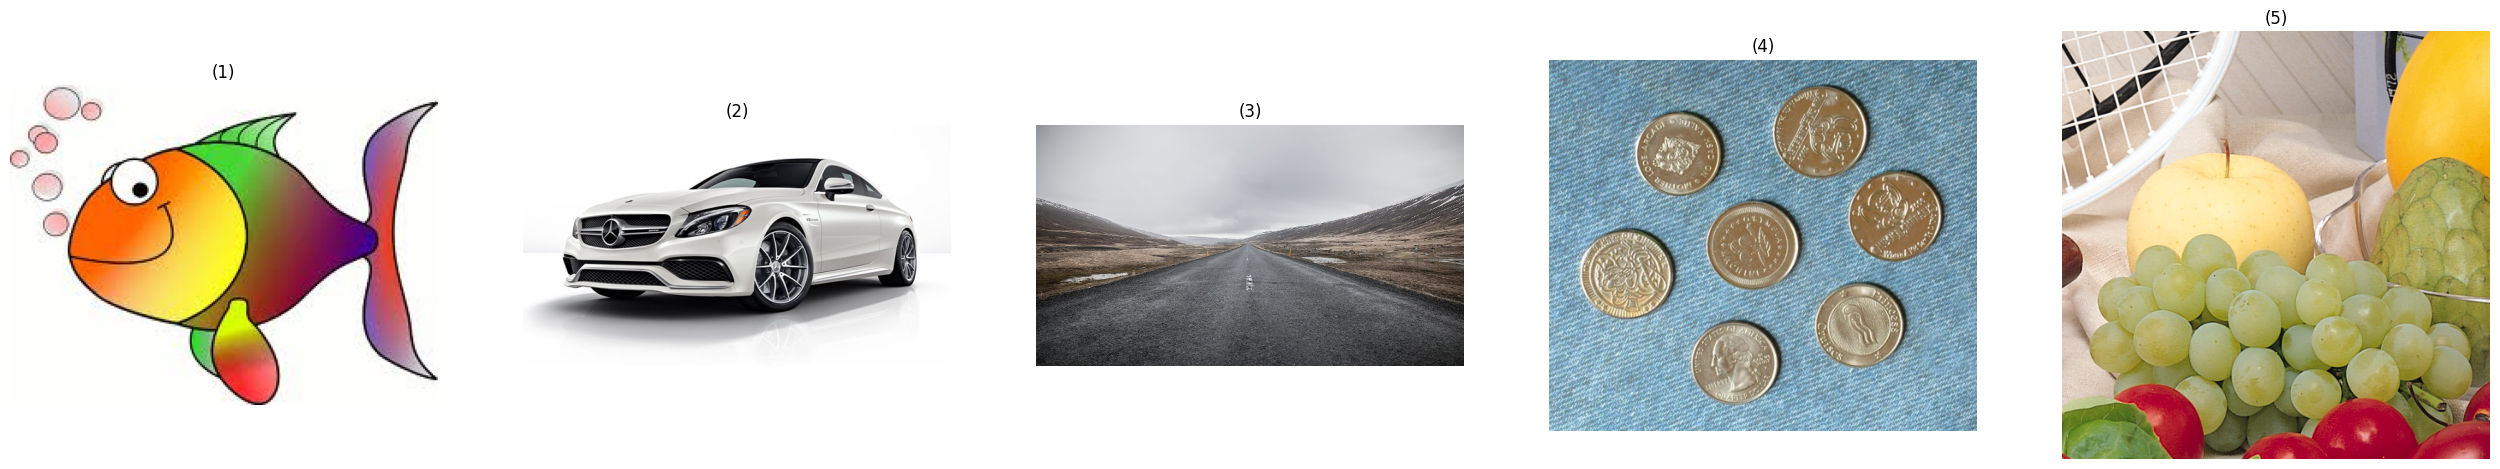

In [6]:
# histogram equalization
# equalized_img = cv2.merge((cv2.equalizeHist(R), cv2.equalizeHist(G), cv2.equalizeHist(B)))
# equalized_img.shape

show_images(imgs)

### Approch 1 (Canny Detection)

In [7]:

#Step3: Using the strel command to obtain a flat morphological structuring element.

def erode_img(img):
    SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(img.shape[0]*.01), int(img.shape[1]*.01)))
    #Step4: To perform grayscale erosion applies imerode function. 
    # smoothed_img = median(equalized_img)
    eroded_img = cv2.erode(img, SE)
    eroded_img = cv2.dilate(eroded_img, SE)
    return eroded_img

eroded_imgs = []
for img in imgs:
    eroded_imgs.append(erode_img(img))


In [15]:

def extract_edges(eroded_img):
    #Step6: Convert the result of step 4 to gray image. 

    img_gray = rgb2gray(eroded_img)
    #Step7: To get a binary image, apply edge function. 
    img_binary = canny(img_gray, sigma=1.0, low_threshold=0.1, high_threshold=0.3)
    #Step8: Binary image is eroded and dilated to remove the noisy pixels at the edges. 
    SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(img.shape[0]*.005), int(img.shape[1]*.005)))
    img_binary = dilation(img_binary, SE)

    SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(img.shape[0]*.01), int(img.shape[1]*.01)))
    img_binary = closing(img_binary, SE)
    # img_binary = dilation(img_binary, SE)

    return img_binary

img_edges = []
for img in eroded_imgs:
    img_edges.append(extract_edges(img))

show_images(imgs)
show_images(eroded_imgs)
show_images(img_edges)

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\filterengine.hpp:367: error: (-215:Assertion failed) anchor.inside(Rect(0, 0, ksize.width, ksize.height)) in function 'cv::normalizeAnchor'


### Approach 2

In [9]:
# #Step5: Subtracting the second matrix from the first matrix 
# subtracted_image = img - eroded_image
# show_images([img, subtracted_image], ["Original", "Subtracted"])

# smoothed_img = median(img)
# show_images([img, smoothed_img], ["Original", "Smoothed"])

# edges = canny(img_gray, sigma=1.2, low_threshold=0.1, high_threshold=0.3)

# show_images([equalized_img, eroded_image, img_binary], ["Original", "filtered", "binary"])


In [10]:
# from skimage import measure

#Step9: Using bwtraceboundary function, boundary of the image is extracted. (2D boundary is perfectly extracted at this point). Let’s call the binary image boundary which contains 2D boundary only.

# Find contours (boundaries) using scikit-image
def draw_contours(img_binary, img):
    img_binary = img_binary.astype(np.uint8)

    
    # Extract contours
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #Select the largest contour (assuming it represents the main boundary)
    # largest_contour = max(contours, key=cv2.contourArea)
    
    # Draw contours on the original image
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

    #find significant contours
    # Set a minimum contour area threshold
    # min_contour_area = img.shape[0]*img.shape[1]*0.001
    min_contour_area = 1000

    # Filter out tiny contours
    significant_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_contour_area]
    img_significant_contours = img.copy()

    # Draw significant contours on the original image
    cv2.drawContours(img_significant_contours, significant_contours, -1, (0, 255, 0), 2)
    
    return img_contours, img_significant_contours, contours, significant_contours

imgs_contours, imgs_significant_contours, imgs_extracted_contours, imgs_extracted_significant_contours = [], [], [], [] 
for bin_img, img in zip(img_edges,imgs):
    img_contours, img_significant_contours, contours, significant_contours = draw_contours(bin_img, img)
    imgs_contours.append(img_contours)
    imgs_significant_contours.append(img_significant_contours)
    imgs_extracted_contours.append(contours)
    imgs_extracted_significant_contours.append(significant_contours)

show_images(imgs_contours)
show_images(imgs_significant_contours)

# # # edge contours
# contour_points = np.array([
#     [[img.shape[1]-2, img.shape[1]-2]],  # Example: Replace with your own contour points
#     [[img.shape[1]-2, 0]],

# ])
# cv2.drawContours(img_contours, [contour_points], -1, (0, 255, 0), 2)

# # Draw the edge contours on the image




# cv2.drawContours(img_contours, [largest_contour], -1, (0, 0, 255), 3)

# show_images([img_contours, img_significant_contours], ["Contours", "Significant Contours"])




<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

In [11]:
#Step10: Fill inside the edges of the image and let’s call this matrix t.
def mask_img(img, img_binary, significant_contours):

    mask = np.zeros_like(img_binary).astype(np.uint8)
    
    for contour in significant_contours:
        cv2.drawContours(mask, [contour], -1, 1, -1)  # Fill the contour

    #fix mask
    SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (min(20, int(img.shape[0]*.03)), min(20, int(img.shape[1]*.03))))
    closed_mask = closing(mask, SE)
    # closed_mask = closing(mask, SE)


    # Find contours in the mask
    contours, hierarchy = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw filled contours
    filled_mask = np.zeros_like(closed_mask)

    # Draw filled contours on the new mask
    cv2.drawContours(filled_mask, contours, -1, 1, cv2.FILLED)

    # show_images([mask, closed_mask, filled_mask], ["Mask", "Opened Mask", "Filled Mask"])
    new_SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (min(10, int(img.shape[0]*.02)), min(10, int(img.shape[1]*.02))))
    # filled_mask = opening(filled_mask, new_SE)

    #Step11: Create three matrices of the same size with the original image.
    final_image = np.zeros_like(img)
    # print(final_image.shape)

    final_image = np.where(filled_mask[...,np.newaxis], img, np.zeros_like(img))

    # show_images([mask, closed_mask, filled_mask,final_image], ["Mask", "Opened Mask", "Filled Mask", "Final Image"])

    return mask, closed_mask, filled_mask, final_image

# masks, closed_masks, filled_masks, final_imgs = [], [], [], []
# for bin_img, img, sig_contours in zip(img_edges, imgs, imgs_extracted_significant_contours):
#     mask, closed_mask, filled_mask, final_img = mask_img(img, bin_img, sig_contours)
#     masks.append(mask)
#     closed_masks.append(closed_mask)
#     filled_masks.append(filled_mask)
#     final_imgs.append(final_img)


# show_images(masks)
# show_images(closed_masks)
# show_images(filled_masks)
# show_images(final_imgs)

# 
#Step12: Compare the matrix in step10


In [12]:
# from joblib import Parallel, delayed



# Parallel(n_jobs=5)(delayed(mask_img)(imgs[i], img_edges[i], imgs_extracted_significant_contours[i]) for i in range(len(imgs)))

masks, closed_masks, filled_masks, final_imgs = [], [], [], []
for bin_img, img, sig_contours in zip(img_edges, imgs, imgs_extracted_significant_contours):
    mask, closed_mask, filled_mask, final_img = mask_img(img, bin_img, sig_contours)
    masks.append(mask)
    closed_masks.append(closed_mask)
    filled_masks.append(filled_mask)
    final_imgs.append(final_img)

In [13]:
show_images(masks)
show_images(closed_masks)
show_images(filled_masks)
show_images(final_imgs)


<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

In [14]:
show_images(masks)
show_images(closed_masks)
show_images(filled_masks)
show_images(final_imgs)


<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

<Figure size 0x0 with 0 Axes>

In [ ]:
imgs[2].shape

(512, 768, 3)

In [ ]:
io.imsave('./out0.jpeg', final_imgs[1])

NameError: name 'io' is not defined